In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
#from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loader = catalog.load(f"{ship}.models")
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[05/22/23 15:51:45] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=821763;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=725630;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/22/23 15:51:46] INFO     Kedro project phd                                                      ]8;id=243860;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=643807;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=384215;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=746674;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=538916;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=717556;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=556097;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=232237;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=761271;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=778799;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=157697;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=86687;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=860159;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=539367;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=229577;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=362645;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
model = model_loader["wpcc.updated.vmm_martins_simple.joined.model"]()

## MDL

In [6]:
time_series

{'wpcc.updated.22611.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7f7d01bfa2c0>>,
 'wpcc.updated.22612.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7f7d01bf8280>>,
 'wpcc.updated.22613.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7f7d25b8caf0>>,
 'wpcc.updated.22614.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7f7cf59966b0>>,
 'wpcc.updated.22615.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7f7d037081c0>>,
 'wpcc.updated.22616.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7f7d037080d0>>,
 'wpcc.updated.22635.ek_smooth': <

In [7]:
data = time_series['wpcc.updated.22774.ek_smooth']()

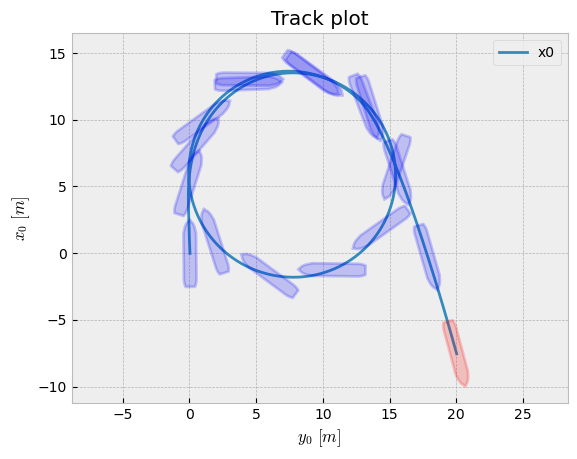

In [8]:
track_plot(df=data, lpp=ship_data['L'], beam=ship_data['B']);

In [9]:
result = model.simulate(data)

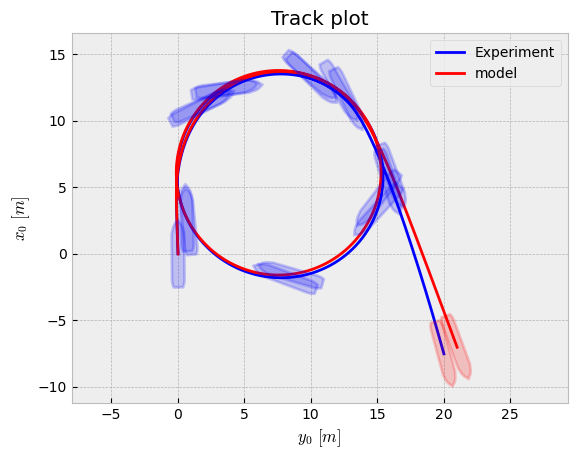

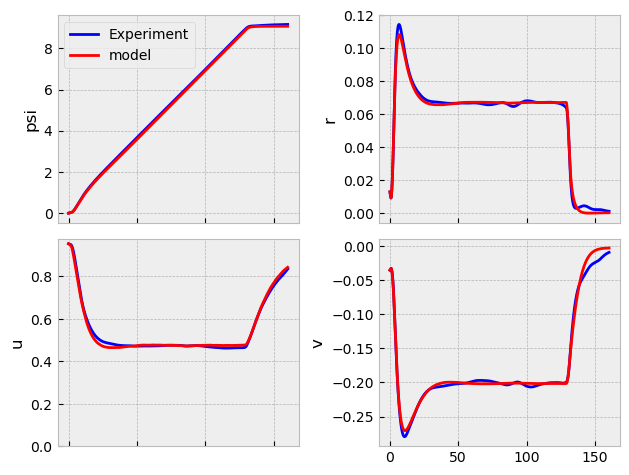

In [10]:
dataframes = {
'Experiment':data.rolling(5).mean(),
'model' : result.result
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
plot(dataframes, keys=['u','v','r','psi'], time_window=time_window);

## Inverse dynamics regression

In [11]:
added_masses = extract_added_masses(parameters=model.parameters)

In [12]:
data_all_MDL = time_series['wpcc.updated.joined.ek_smooth']()

In [13]:
#data_with_force = predict_force(data=data.rolling(window=2).mean().dropna(), added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
data_with_force = predict_force(data=data_all_MDL, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

#data_with_force = predict_force(data=data_ek, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

In [28]:
from vmm_abkowitz_diminished import vmm as vmm
regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.854
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                          1.408e+05
Date:                Mon, 22 May 2023   Prob (F-statistic):                        0.00
Time:                        15:59:29   Log-Likelihood:                      6.6225e+05
No. Observations:               96500   AIC:                                 -1.324e+06
Df Residuals:                   96496   BIC:                                 -1.324e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Xu            5.08e-05    9.7e-07     52.366      0.000    4.89e-05    5.27e-05
Xdeltadelta    -0.0007   2.22e-05    -33.271      0.000      -0.001      -0.001
Xvv             0.0349      0.000    238.151      0.000       0.035       0.035
Xvr             0.0141   9.91e-05    141.799      0.000       0.014       0.014
==============================================================================
Omnibus:                    16372.621   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           369929.402
Skew:                          -0.035   Prob(JB):                         0.00
Kurtosis:                      12.592   Cond. No.                         213.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.147e+07
Date:                Mon, 22 May 2023   Prob (F-statistic):                        0.00
Time:                        15:59:29   Log-Likelihood:                      6.8345e+05
No. Observations:               96500   AIC:                                 -1.367e+06
Df Residuals:                   96499   BIC:                                 -1.367e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yv            -0.0187   4.04e-06  -4633.526      0.000      -0.019      -0.019
==============================================================================
Omnibus:                    46137.419   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1310676.380
Skew:                           1.724   Prob(JB):                         0.00
Kurtosis:                      20.722   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          4.463e+05
Date:                Mon, 22 May 2023   Prob (F-statistic):                        0.00
Time:                        15:59:29   Log-Likelihood:                      8.4537e+05
No. Observations:               96500   AIC:                                 -1.691e+06
Df Residuals:                   96495   BIC:                                 -1.691e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0024    2.5e-06   -959.955      0.000      -0.002      -0.002
Nr            -0.0025   4.38e-06   -560.405      0.000      -0.002      -0.002
Nv            -0.0004   5.57e-06    -66.773      0.000      -0.000      -0.000
Nrrr           0.0013   8.05e-06    162.732      0.000       0.001       0.001
Nvvv           0.0065   3.61e-05    178.956      0.000       0.006       0.007
==============================================================================
Omnibus:                    87925.746   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8813936.653
Skew:                          -4.031   Prob(JB):                         0.00
Kurtosis:                      49.120   Cond. No.                         130.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

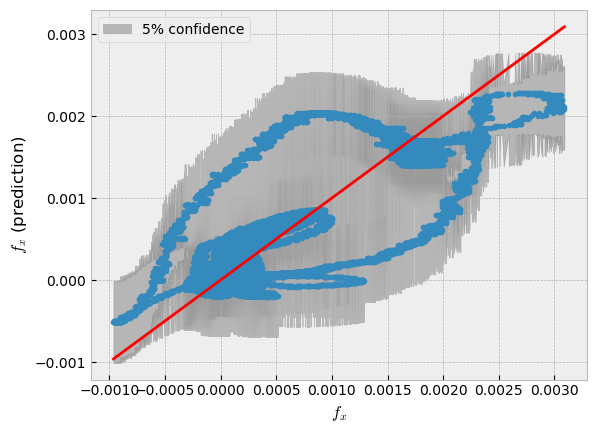

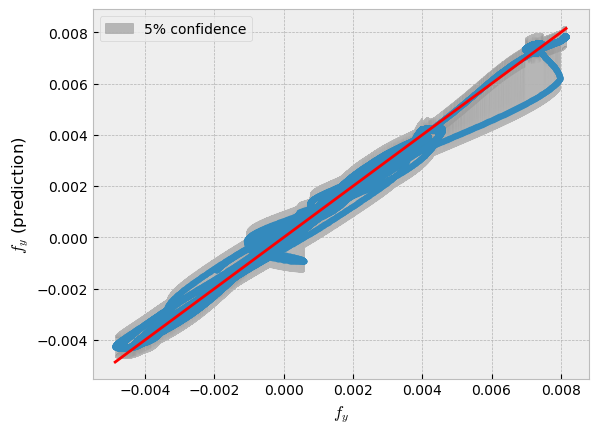

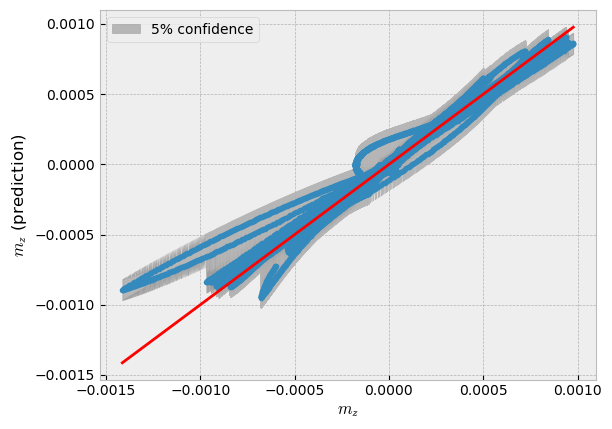

In [29]:
regression.show()

In [16]:
model_no_thrust = create_model_from_motion_regression(regression=regression)
model_no_thrust.control_keys = ['delta']

In [17]:
result_no_thrust = model_no_thrust.simulate(data)

In [18]:
data['beta'] = -np.arctan2(data['v'],data['u'])

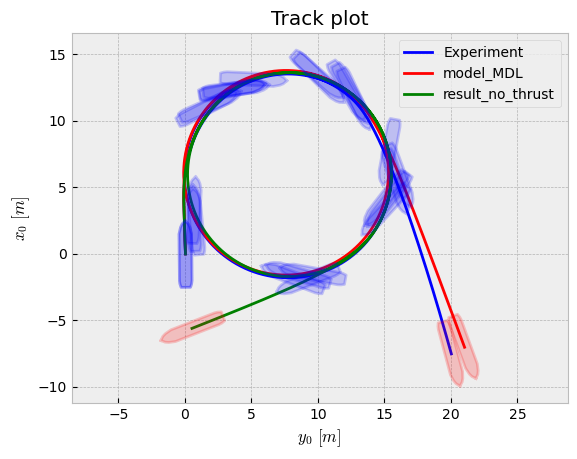

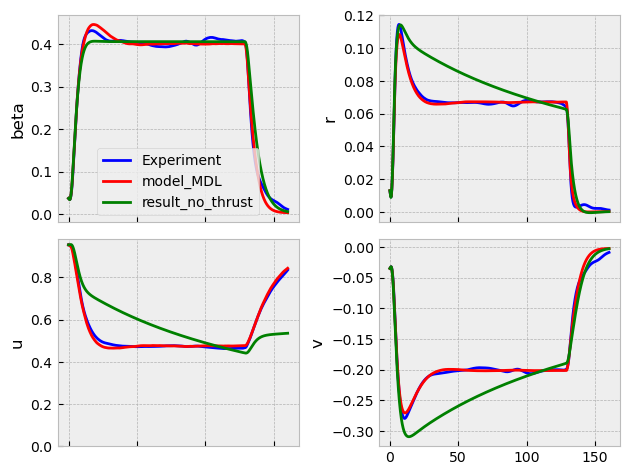

In [19]:
dataframes = {
'Experiment':data.rolling(5).mean(),
'model_MDL' : result.result,
'result_no_thrust': result_no_thrust.result,
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
plot(dataframes, keys=['u','v','r','beta'], time_window=time_window);

In [20]:
data2 = time_series['wpcc.updated.22773.ek_smooth']()
result2_no_thrust = model_no_thrust.simulate(data2)
result2 = model.simulate(data2)

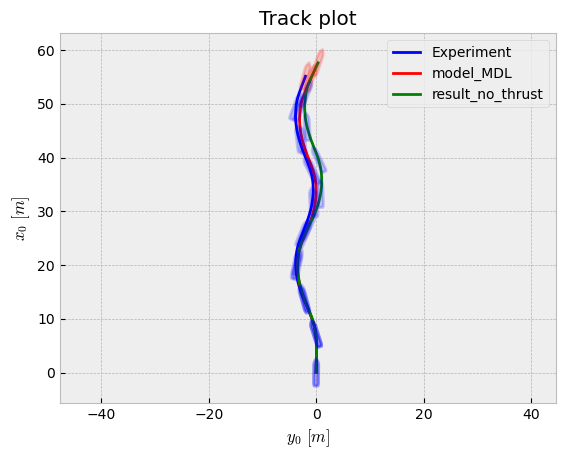

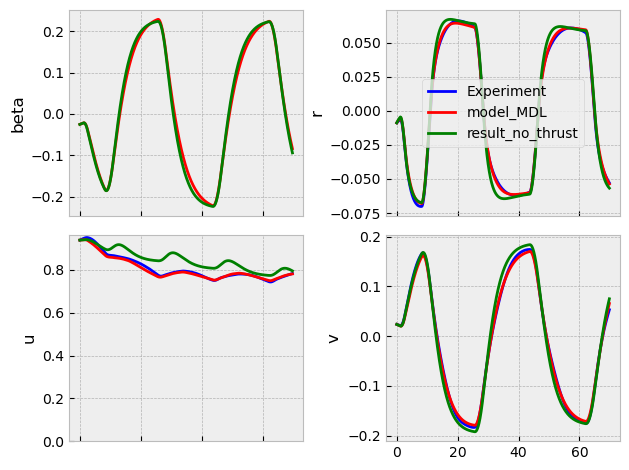

In [21]:
dataframes = {
'Experiment':data2.rolling(5).mean(),
'model_MDL' : result2.result,
'result_no_thrust': result2_no_thrust.result,
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
plot(dataframes, keys=['u','v','r','beta'], time_window=time_window);

In [22]:
models = {key:loader for key,loader in model_loader.items()}
models["vmm_abkowitz_diminished"] = model_no_thrust
catalog.save(f"{ship}.models",models)

[05/22/23 15:52:04] INFO     Saving data to 'wPCC.models' (PartitionedDataSet)...               ]8;id=618038;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=158355;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [23]:
results = {}
for key, loader in time_series.items():
    data2 = loader()
    
    try:
        result2_no_thrust = model_no_thrust.simulate(data2)
    except Exception:
        log.error(f"Failed to simulate:{key}")
    else:
        results[key] = result2_no_thrust.result.copy() 

[05/22/23 15:55:05] ERROR    Failed to simulate:wpcc.updated.joined.ek_smooth                       ]8;id=977841;file:///tmp/ipykernel_5552/1464821124.py\1464821124.py]8;;\:]8;id=891049;file:///tmp/ipykernel_5552/1464821124.py#8\8]8;;\

In [24]:
catalog.save(f"{ ship }.simulation_MDL_vmm_abkowitz_diminished", results)

                    INFO     Saving data to 'wPCC.simulation_MDL_vmm_abkowitz_diminished'       ]8;id=56088;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=873022;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\
                             (PartitionedDataSet)...                                                               

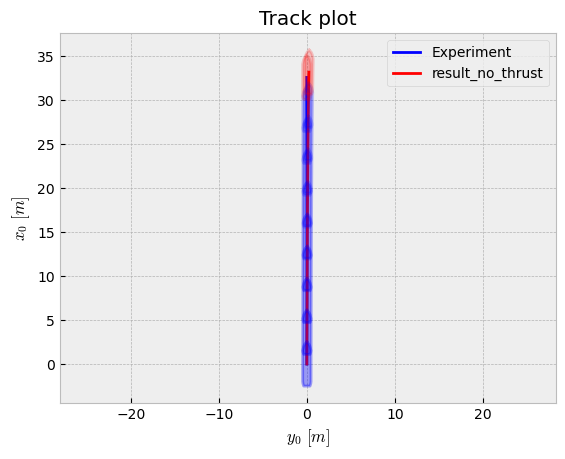

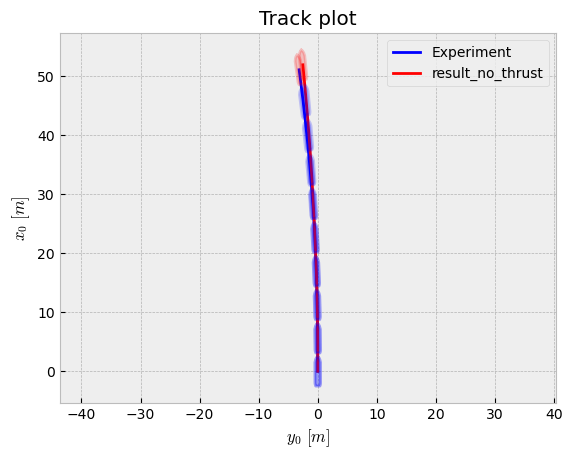

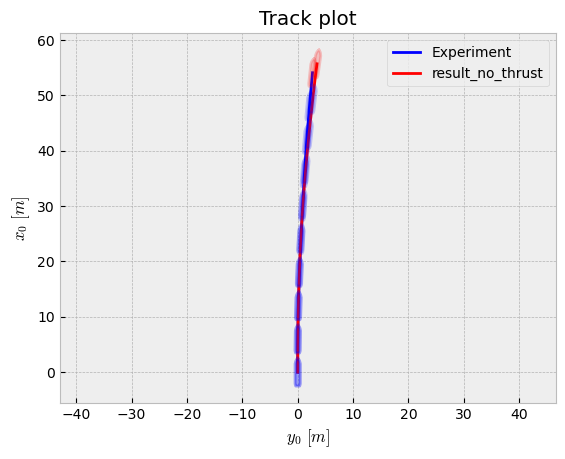

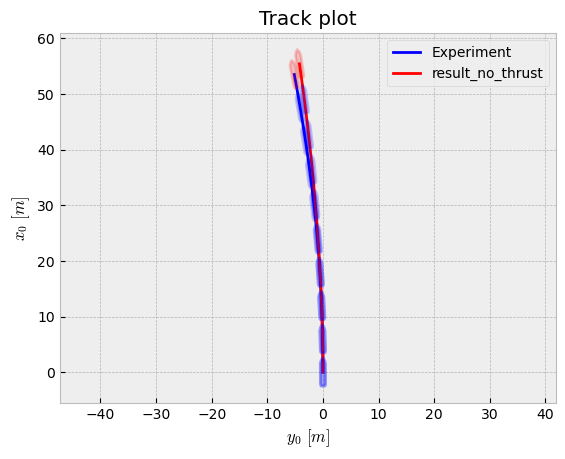

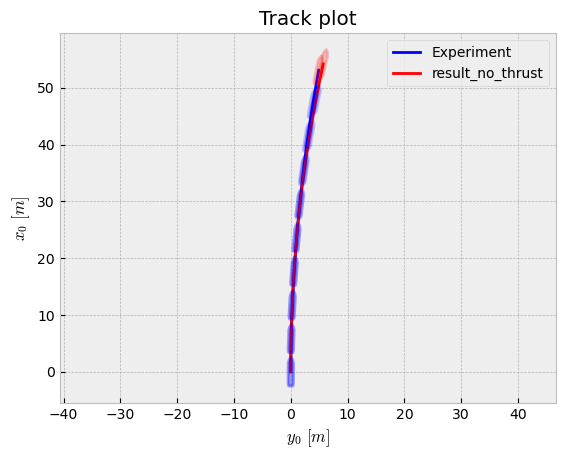

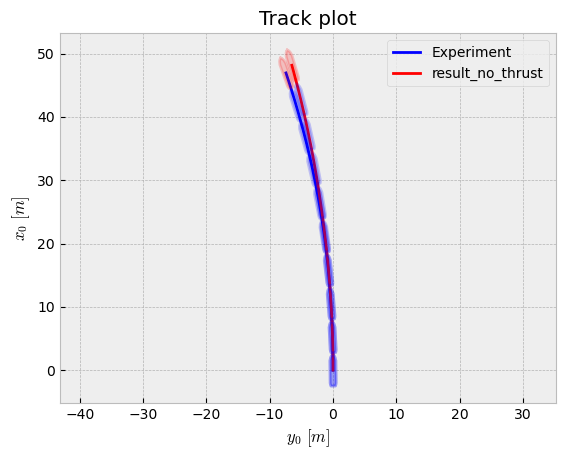

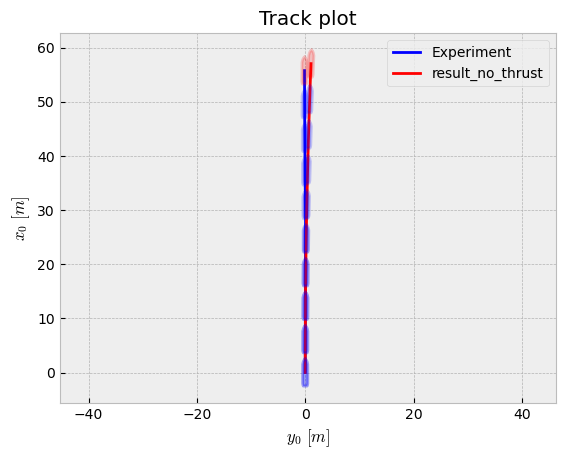

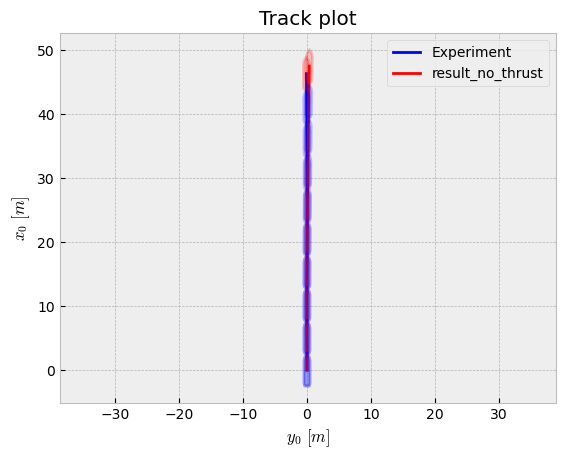

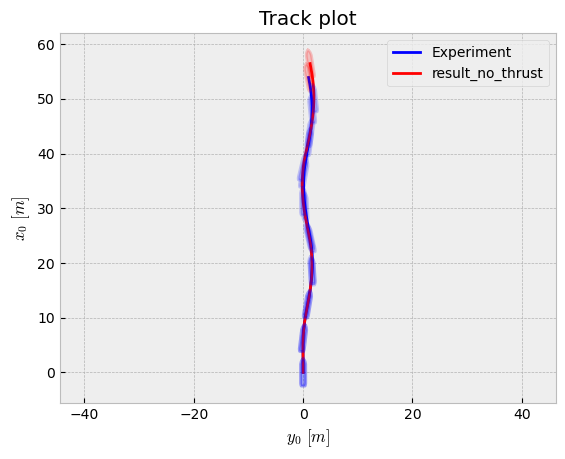

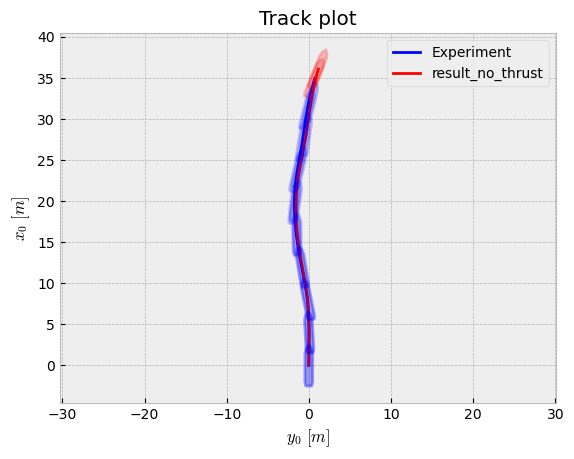

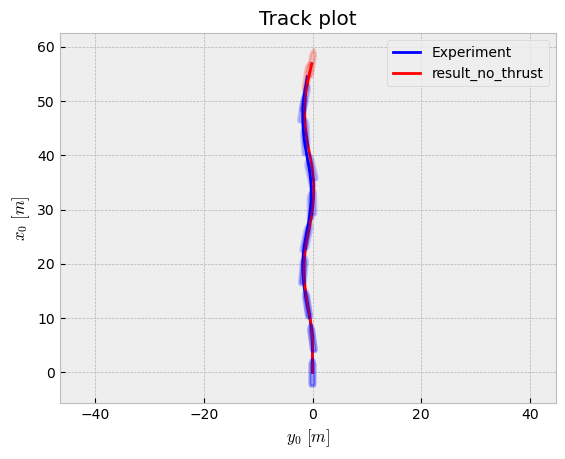

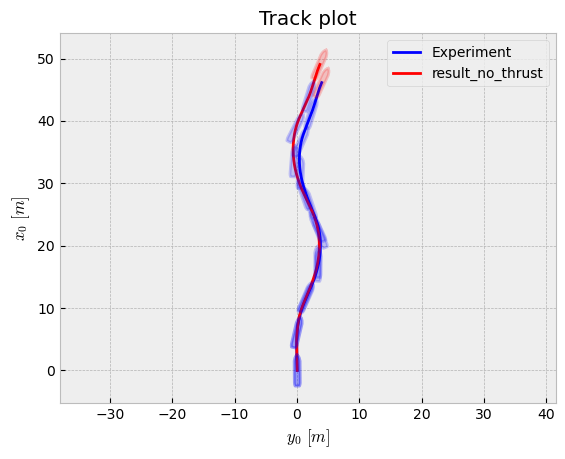

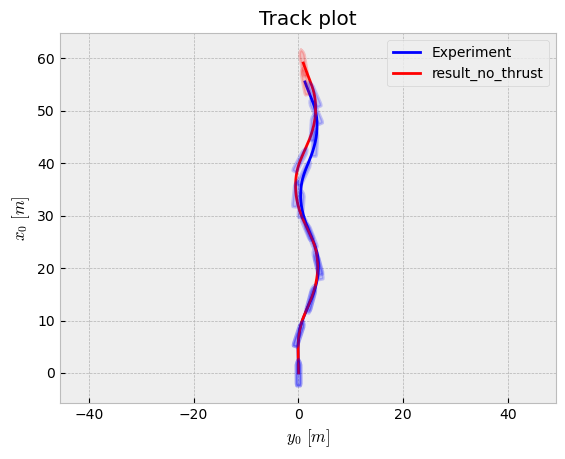

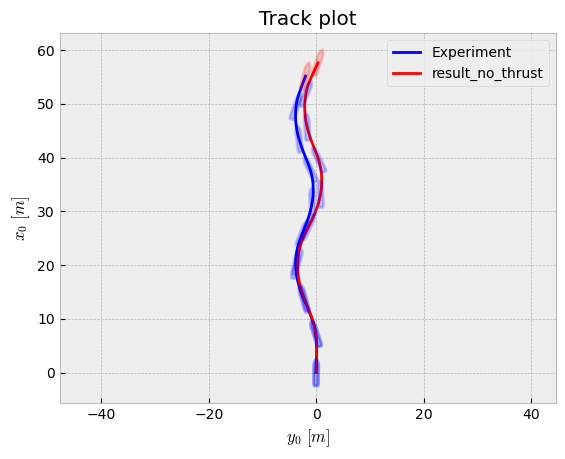

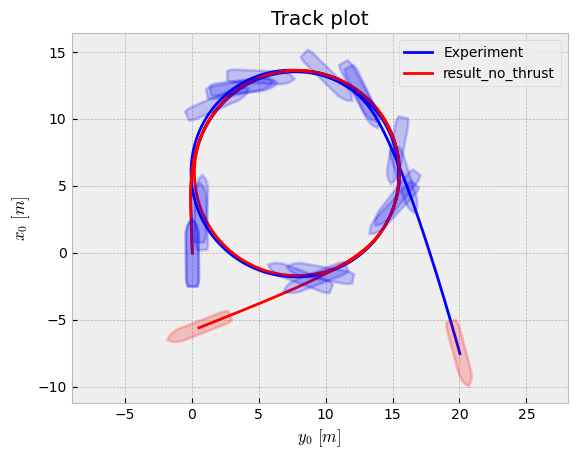

In [25]:
for key, sim_result in results.items():
    
    data2 = time_series[key]()
    
    dataframes = {
    'Experiment':data2,
    'result_no_thrust': sim_result,
    }
    time_window=[0, np.inf]
    ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=10);
    
    